## Imports

In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
import scipy.stats as stats
from scipy.stats import uniform, randint
from xgboost import XGBRegressor, XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import InconsistentVersionWarning

# 1. Ignore version mismatch warnings from old pickled models
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# 2. Ignore that delayed/Parallel warning
warnings.filterwarnings(
    "ignore",
    message="`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel`"
)

# 3. Ignore sklearn FutureWarnings (like force_int_remainder_cols)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 40)

## Read clean data

In [2]:
df = pd.read_csv("cleaned_medical_insurance.csv", keep_default_na=False)
df

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,...,risk_score,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,27.4,Never,Never,2,0,0,4,121.0,76.0,123.8,...,0.5714,4672.59,1,0,0,0,0,0,0,0,0,1,0,1,0,2,0,1,0,0
1,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,30.5,Never,Daily,3,0,0,2,136.0,83.0,171.0,...,0.8681,1002.24,2,1,0,0,0,0,0,0,0,1,0,2,0,1,1,0,1,0
2,63,Female,North,Rural,305000.0,HS,Single,Employed,3,2,20.4,Never,Daily,1,0,0,2,137.0,96.0,69.2,...,0.6923,1220.04,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,36,Male,West,Rural,38900.0,Masters,Single,Employed,1,0,21.6,Never,Occasional,0,0,0,0,114.0,76.0,153.9,...,0.1978,0.00,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
4,21,Female,South,Suburban,83700.0,HS,Single,Employed,3,2,30.7,Never,Weekly,3,0,0,1,82.0,64.0,189.0,...,0.3187,1406.06,1,0,1,0,0,0,0,0,0,0,0,2,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83822,50,Male,West,Urban,127200.0,No HS,Married,Employed,2,0,28.2,Never,Occasional,0,0,0,1,115.0,74.0,102.5,...,0.3516,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
83823,42,Male,East,Suburban,21600.0,HS,Married,Employed,2,0,27.6,Never,Occasional,0,0,0,1,101.0,66.0,177.1,...,0.2637,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83824,41,Male,West,Rural,81900.0,HS,Divorced,Unemployed,1,0,29.8,Former,Weekly,7,0,0,1,128.0,83.0,118.8,...,0.4505,2500.48,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
83825,51,Female,South,Urban,43400.0,Doctorate,Single,Unemployed,3,2,21.9,Never,Occasional,4,0,0,2,110.0,73.0,134.9,...,0.5604,1104.76,1,0,0,0,0,0,0,0,0,0,1,0,0,2,2,1,0,0


## 2 Part Model

### 1. Define input features and target
### 2. Transform the input features
### 3. Train-test Split

In [3]:
target = "total_claims_paid"

# Define feature matrix X and target y
y = df[target]
X = df.drop(columns=[target])

# Identify categorical & numeric predictors
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Part 1: binary indicator
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

# Part 2: positive only
X_train_pos = X_train[y_train > 0]
y_train_pos = y_train[y_train > 0]

X_test_pos = X_test[y_test > 0]
y_test_pos = y_test[y_test > 0]

preprocessor.fit(X_train)
X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_pos_trans = preprocessor.transform(X_train_pos)
X_test_pos_trans = preprocessor.transform(X_test_pos)

### Part 1 (Claim Probability)

Best classifier params: {'colsample_bytree': np.float64(0.6479461469334731), 'gamma': np.float64(4.038536542632651), 'learning_rate': np.float64(0.10429097039125192), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 101, 'reg_alpha': np.float64(0.363629602379294), 'reg_lambda': np.float64(2.4435641654419213), 'subsample': np.float64(0.9849789179768444)}


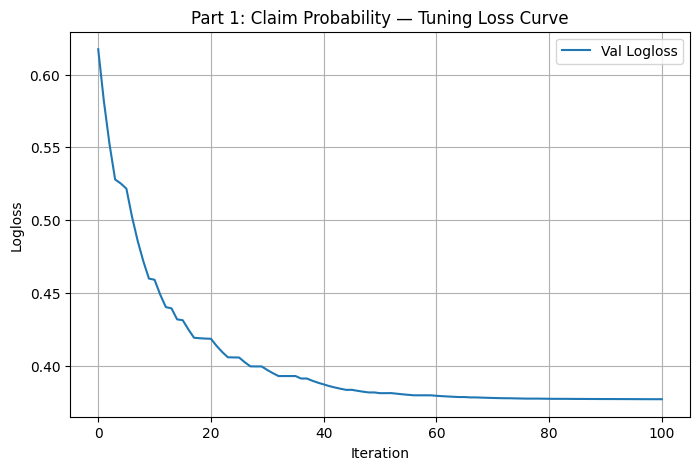

In [4]:
clf_param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": randint(3, 5),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(3, 10),
    "gamma": uniform(1, 9),
    "reg_lambda": uniform(0.5, 2),
    "reg_alpha": uniform(0, 1)
}

clf_base = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

clf_search = RandomizedSearchCV(
    estimator=clf_base,
    param_distributions=clf_param_dist,
    n_iter=36,
    cv=5,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=False
)

clf_search.fit(X_train_trans, y_train_binary)
clf_best = clf_search.best_estimator_
print("Best classifier params:", clf_search.best_params_)


clf_best.fit(
    X_train_trans, y_train_binary,
    eval_set=[(X_test_trans, y_test_binary)],
    verbose=False
)

results_clf = clf_best.evals_result()
plt.figure(figsize=(8,5))
plt.plot(results_clf["validation_0"]["logloss"], label="Val Logloss")
plt.title("Part 1: Claim Probability — Tuning Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Logloss")
plt.grid()
plt.legend()
plt.show()



In [5]:
# ============================
# PART 1 — CLASSIFICATION METRICS
# ============================

# Train predictions
train_prob_claim = clf_best.predict_proba(X_train_trans)[:, 1]
train_pred_binary = (train_prob_claim > 0.5).astype(int)

# Test predictions
test_prob_claim = clf_best.predict_proba(X_test_trans)[:, 1]
test_pred_binary = (test_prob_claim > 0.5).astype(int)

# Train metrics
train_auc = roc_auc_score(y_train_binary, train_prob_claim)

# Test metrics
test_auc = roc_auc_score(y_test_binary, test_prob_claim)

print("\n=== PART 1: Claim Probability — Train vs Test ===")
print(f"Train ROC-AUC:      {train_auc:.4f}")
print(f"Test ROC-AUC:       {test_auc:.4f}")



=== PART 1: Claim Probability — Train vs Test ===
Train ROC-AUC:      0.8737
Test ROC-AUC:       0.8632


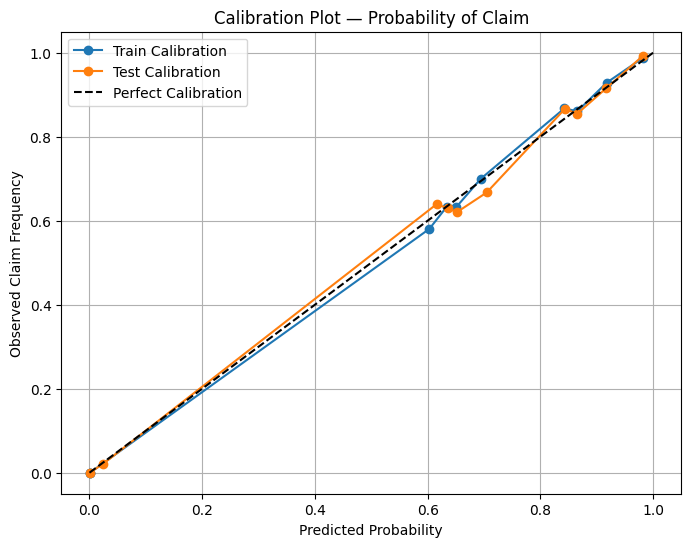

In [6]:
# Part 1 predictions (probabilities)
train_prob = clf_best.predict_proba(X_train_trans)[:, 1]
test_prob  = clf_best.predict_proba(X_test_trans)[:, 1]

y_train_binary = (y_train > 0).astype(int)
y_test_binary  = (y_test > 0).astype(int)

# ---------------------------------------
# Calibration curves (prob_true, prob_pred)
# ---------------------------------------
prob_true_train, prob_pred_train = calibration_curve(y_train_binary, train_prob, n_bins=10, strategy='quantile')
prob_true_test, prob_pred_test = calibration_curve(y_test_binary, test_prob, n_bins=10, strategy='quantile')

# ---------------------------------------
# Plot
# ---------------------------------------
plt.figure(figsize=(8,6))

plt.plot(prob_pred_train, prob_true_train, "o-", label="Train Calibration")
plt.plot(prob_pred_test, prob_true_test, "o-", label="Test Calibration")

# Perfect calibration line
plt.plot([0,1], [0,1], "k--", label="Perfect Calibration")

plt.title("Calibration Plot — Probability of Claim")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Claim Frequency")
plt.legend()
plt.grid(True)
plt.show()


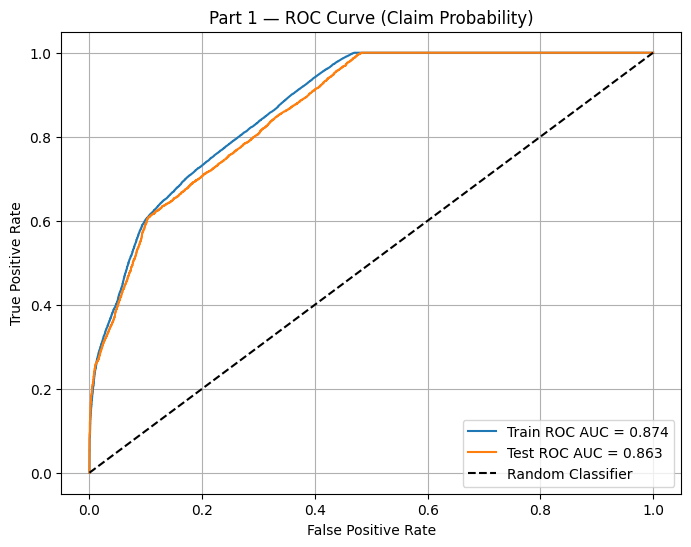

In [7]:
train_prob = clf_best.predict_proba(X_train_trans)[:, 1]
test_prob  = clf_best.predict_proba(X_test_trans)[:, 1]

# -----------------------
# ROC CURVE — TRAIN
# -----------------------
fpr_train, tpr_train, _ = roc_curve(y_train_binary, train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# -----------------------
# ROC CURVE — TEST
# -----------------------
fpr_test, tpr_test, _ = roc_curve(y_test_binary, test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# -----------------------
# PLOT ROC CURVES
# -----------------------
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC = {roc_auc_train:.3f}")
plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC = {roc_auc_test:.3f}")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")

plt.title("Part 1 — ROC Curve (Claim Probability)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


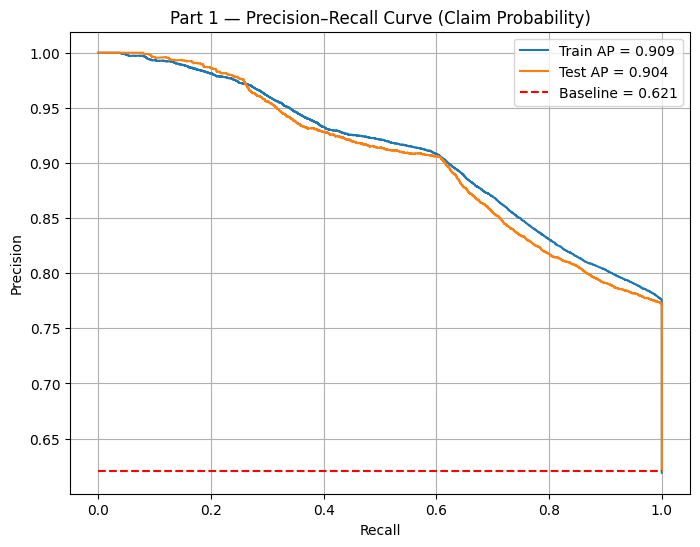

In [8]:
# -----------------------
# PR CURVE — TRAIN
# -----------------------
precision_train, recall_train, _ = precision_recall_curve(y_train_binary, train_prob)
ap_train = average_precision_score(y_train_binary, train_prob)

# -----------------------
# PR CURVE — TEST
# -----------------------
precision_test, recall_test, _ = precision_recall_curve(y_test_binary, test_prob)
ap_test = average_precision_score(y_test_binary, test_prob)

# -----------------------
# PLOT PR CURVES
# -----------------------
plt.figure(figsize=(8,6))
plt.plot(recall_train, precision_train, label=f"Train AP = {ap_train:.3f}")
plt.plot(recall_test, precision_test, label=f"Test AP = {ap_test:.3f}")

# baseline = prevalence of positives
baseline = y_test_binary.mean()
plt.hlines(baseline, xmin=0, xmax=1, colors="red", linestyles="--",
           label=f"Baseline = {baseline:.3f}")

plt.title("Part 1 — Precision–Recall Curve (Claim Probability)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()


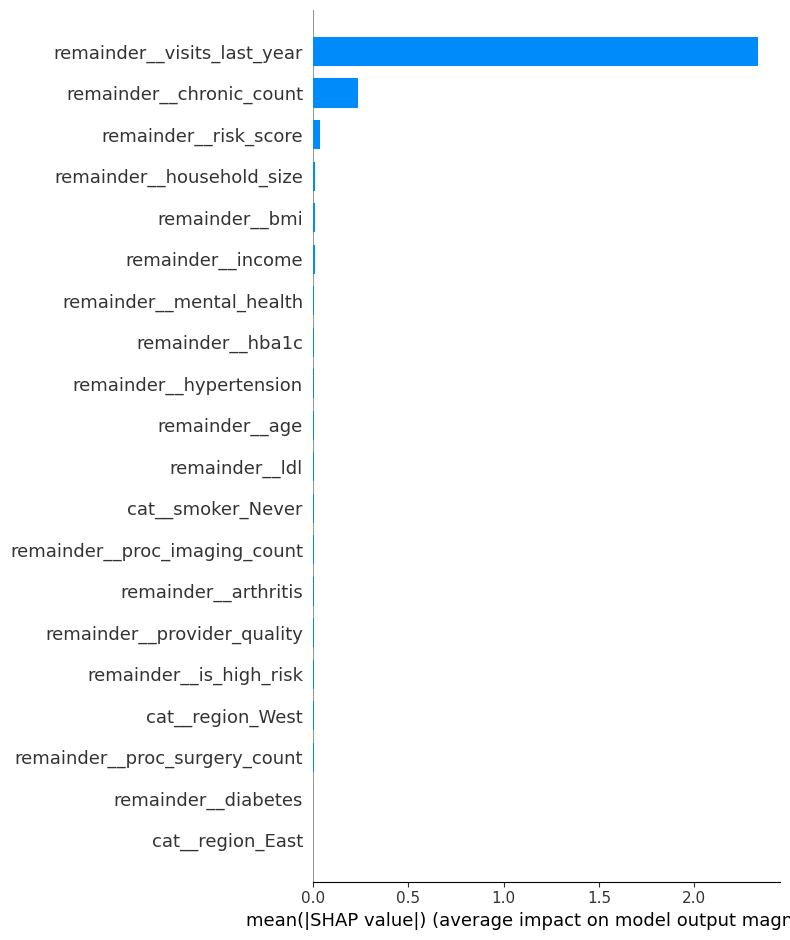

In [9]:
import shap

def to_dense(X):
    return X.toarray() if hasattr(X, "toarray") else X

X_train_clf = to_dense(X_train_trans)
X_test_clf  = to_dense(X_test_trans)

explainer_clf = shap.TreeExplainer(clf_best)
shap_values_clf = explainer_clf.shap_values(X_test_clf)
feature_names_clf = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values_clf, X_test_clf, feature_names=feature_names_clf, plot_type="bar")

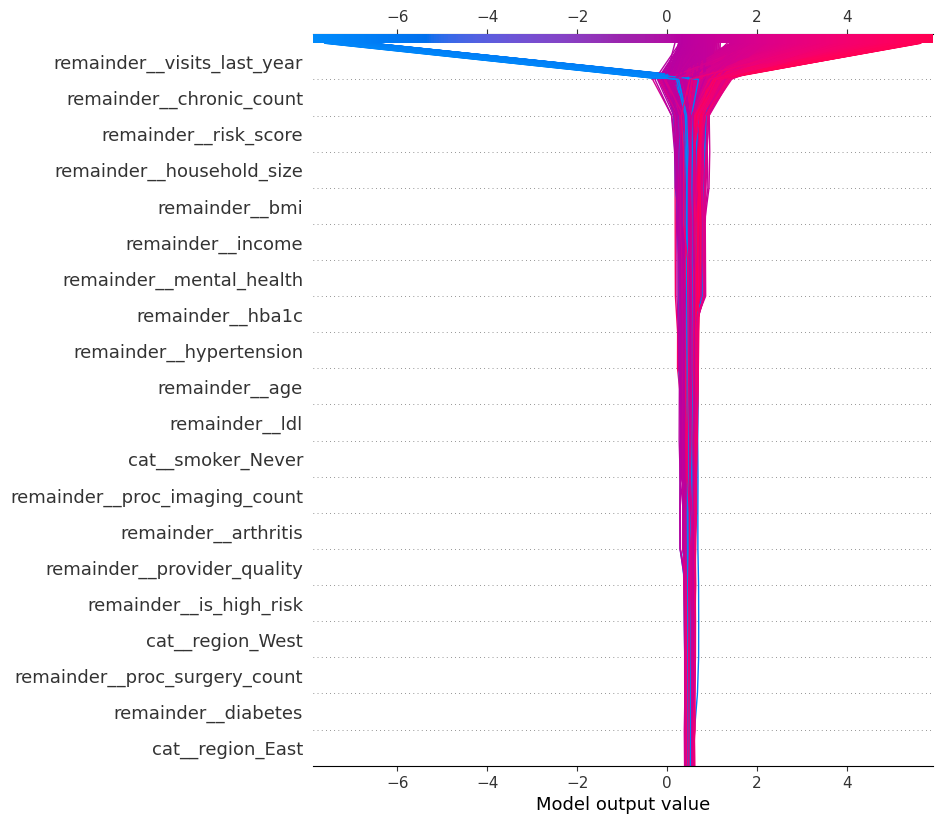

In [10]:
shap.decision_plot(explainer_clf.expected_value, shap_values_clf, feature_names=feature_names_clf, ignore_warnings=True)

### Part 2 (Claim Severity)

Best regressor params: {'colsample_bytree': np.float64(0.7881202537784153), 'gamma': np.float64(10.850808268053587), 'learning_rate': np.float64(0.04988244424445531), 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 108, 'reg_alpha': np.float64(0.18651851039985423), 'reg_lambda': np.float64(0.5815502831095278), 'subsample': np.float64(0.8363571772752967)}


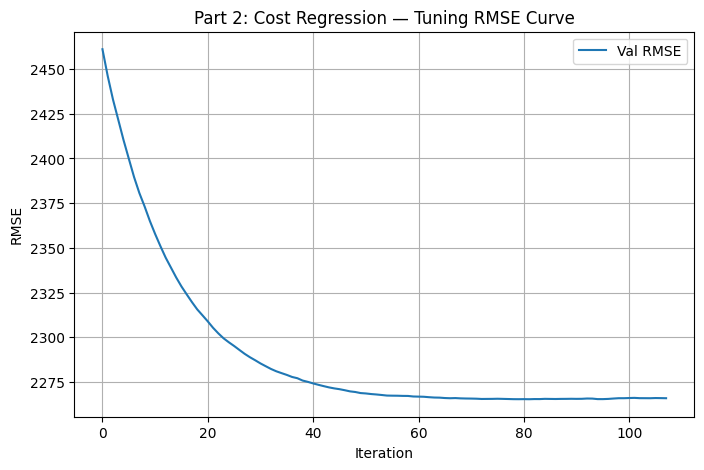

In [11]:
reg_param_dist = {
    "n_estimators": randint(50, 150),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.1),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(5, 12),
    "gamma": uniform(2, 9),
    "reg_lambda": uniform(0.5, 2),
    "reg_alpha": uniform(0, 1)
}

reg_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

reg_search = RandomizedSearchCV(
    estimator=reg_base,
    param_distributions=reg_param_dist,
    n_iter=36,
    cv=5,
    scoring="neg_mean_absolute_error",
    random_state=42,
    n_jobs=-1,
    verbose=False
)

reg_search.fit(X_train_pos_trans, y_train_pos)
reg_best = reg_search.best_estimator_
print("Best regressor params:", reg_search.best_params_)

reg_best.fit(
    X_train_pos_trans, y_train_pos,
    eval_set=[(X_test_pos_trans, y_test_pos)],
    verbose=False
)

results_reg = reg_best.evals_result()
plt.figure(figsize=(8,5))
plt.plot(results_reg["validation_0"]["rmse"], label="Val RMSE")
plt.title("Part 2: Cost Regression — Tuning RMSE Curve")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()


In [12]:
# ============================
# PART 2 — REGRESSION METRICS
# ============================

# Train predictions (positive cases only)
train_pred_cost = reg_best.predict(X_train_pos_trans)

# Test predictions (positive cases only)
test_pred_cost = reg_best.predict(X_test_pos_trans)

def report_metrics(label, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{label} Metrics")
    print(f"MAE:  ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²:   {r2:.4f}")

print("\n=== PART 2: Claim Amount (Positive Claims Only) — Train vs Test ===")

report_metrics("Train", y_train_pos, train_pred_cost)
report_metrics("Test", y_test_pos, test_pred_cost)


=== PART 2: Claim Amount (Positive Claims Only) — Train vs Test ===

Train Metrics
MAE:  $1,318.34
RMSE: $2,163.85
R²:   0.2127

Test Metrics
MAE:  $1,342.75
RMSE: $2,265.93
R²:   0.1637


In [13]:
# ============================
# PART 3 — FULL TWO-PART MODEL METRICS (FIXED)
# ============================

# ----------------
# TRAIN SET
# ----------------
train_pred_cost_if_claim = np.zeros(len(X_train_trans))

# mask for positive historical claims
train_mask_pos = (y_train > 0)

# predict only for those with actual claims
train_pred_cost_pos = reg_best.predict(X_train_trans[train_mask_pos])
train_pred_cost_if_claim[train_mask_pos] = train_pred_cost_pos

# expected claim cost: p(has_claim) * predicted severity
train_expected_cost = train_prob_claim * train_pred_cost_if_claim


# ----------------
# TEST SET
# ----------------
test_pred_cost_if_claim = np.zeros(len(X_test_trans))

test_mask_pos = (y_test > 0)
test_pred_cost_pos = reg_best.predict(X_test_trans[test_mask_pos])
test_pred_cost_if_claim[test_mask_pos] = test_pred_cost_pos

test_expected_cost = test_prob_claim * test_pred_cost_if_claim


# # ----------------
# # COMPUTE METRICS
# # ----------------

print("\n=== FULL TWO-PART MODEL — Train vs Test ===")

report_metrics("Train", y_train, train_expected_cost)
report_metrics("Test", y_test, test_expected_cost)


=== FULL TWO-PART MODEL — Train vs Test ===

Train Metrics
MAE:  $779.14
RMSE: $1,729.30
R²:   0.3706

Test Metrics
MAE:  $796.66
RMSE: $1,812.92
R²:   0.3287


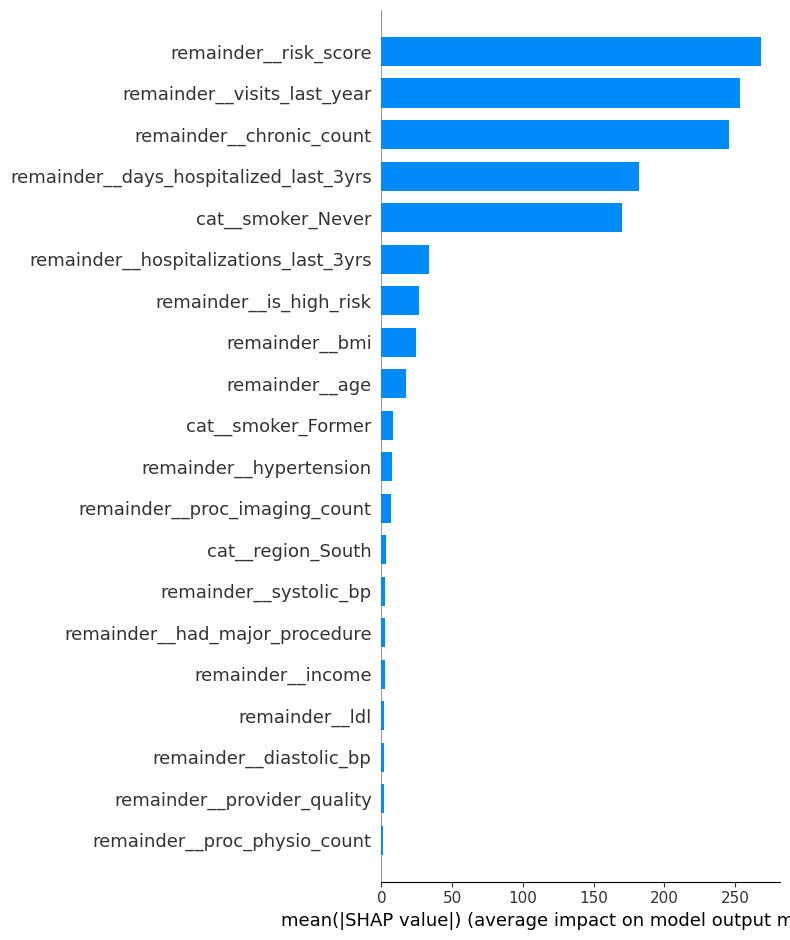

In [14]:
X_train_reg = to_dense(X_train_pos_trans)
X_test_reg  = to_dense(X_test_pos_trans)

explainer_reg = shap.TreeExplainer(reg_best)
shap_values_reg = explainer_reg.shap_values(X_test_reg)
feature_names_reg = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values_reg, X_test_reg, feature_names=feature_names_reg, plot_type="bar")

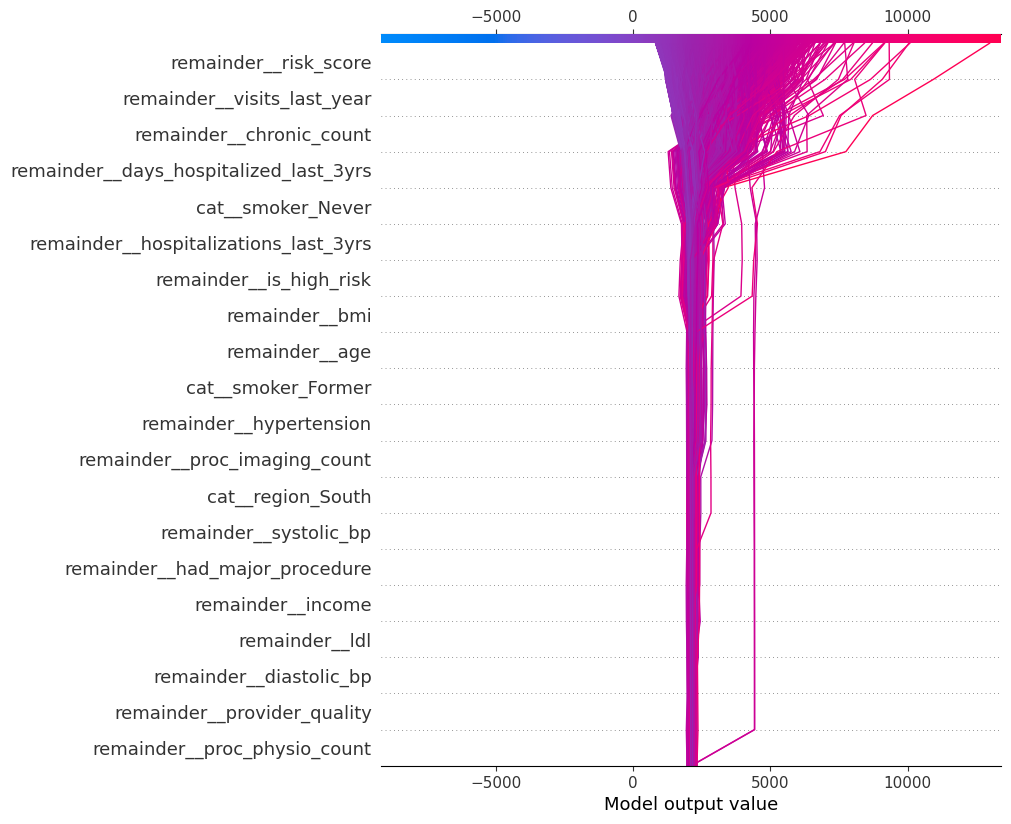

In [15]:
shap.decision_plot(explainer_reg.expected_value, shap_values_reg, feature_names=feature_names_reg, ignore_warnings=True)